# Import packages and load data

In [2]:
import msgspec
import pandas as pd
import numpy as np
import ast
from collections import Counter
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns
import nltk
from wordcloud import WordCloud
from gensim.models import Word2Vec
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

### Warnings
import warnings
### Text Preprocessing and Natural Language Processing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import nltk
import re
from wordcloud import WordCloud

## Dataset 1: Business (From Yelp)

In [3]:
def stream_jsonl(filename):
    with open(filename, "r", encoding="utf-8") as file:
        for i, line in enumerate(file):
            yield msgspec.json.decode(line.strip())


# Convert streamed data to a Pandas DataFrame
business_data_raw = pd.DataFrame(stream_jsonl(
    "yelp_academic_dataset_business.json"))
print("Dataframe Shape:", business_data_raw.shape)
business_data_raw.head(3)

Dataframe Shape: (150346, 14)


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."


In [4]:
business_data_raw.info()
business_data_raw.describe().round(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   150346 non-null  object 
 1   name          150346 non-null  object 
 2   address       150346 non-null  object 
 3   city          150346 non-null  object 
 4   state         150346 non-null  object 
 5   postal_code   150346 non-null  object 
 6   latitude      150346 non-null  float64
 7   longitude     150346 non-null  float64
 8   stars         150346 non-null  float64
 9   review_count  150346 non-null  int64  
 10  is_open       150346 non-null  int64  
 11  attributes    136602 non-null  object 
 12  categories    150243 non-null  object 
 13  hours         127123 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 16.1+ MB


,latitude,longitude,stars,review_count,is_open
count,150346.00,150346.00,150346.00,150346.00,150346.0
mean,36.67,-89.36,3.60,44.87,0.8
std,5.87,14.92,0.97,121.12,0.4
min,27.56,-120.10,1.00,5.00,0.0
25%,32.19,-90.36,3.00,8.00,1.0
50%,38.78,-86.12,3.50,15.00,1.0
75%,39.95,-75.42,4.50,37.00,1.0
max,53.68,-73.20,5.00,7568.00,1.0


### Subsampling Strategy

#### Filtering for Active Restaurants
Retained only businesses where is_open equals to 1, ensuring that the recommendation system suggests operational restaurants.

In [5]:
biz = business_data_raw[business_data_raw['is_open'] == 1].copy()
biz.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119698 entries, 1 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   119698 non-null  object 
 1   name          119698 non-null  object 
 2   address       119698 non-null  object 
 3   city          119698 non-null  object 
 4   state         119698 non-null  object 
 5   postal_code   119698 non-null  object 
 6   latitude      119698 non-null  float64
 7   longitude     119698 non-null  float64
 8   stars         119698 non-null  float64
 9   review_count  119698 non-null  int64  
 10  is_open       119698 non-null  int64  
 11  attributes    107350 non-null  object 
 12  categories    119603 non-null  object 
 13  hours         103603 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 13.7+ MB


#### Focusing on Pennsylvania (PA)
Since Pennsylvania had the highest representation in the dataset, we filtered businesses to include only those within PA, allowing for a well-defined geographic scope.

In [6]:
biz.groupby("state")["business_id"].count().sort_values(ascending=False)

state
PA     26289
FL     21540
TN      9600
IN      8946
MO      8363
AZ      8108
LA      7676
NJ      7031
NV      6277
AB      4346
CA      4065
ID      3783
DE      1894
IL      1765
TX         4
WA         2
MA         2
VT         1
UT         1
MI         1
SD         1
HI         1
CO         1
XMS        1
Name: business_id, dtype: int64

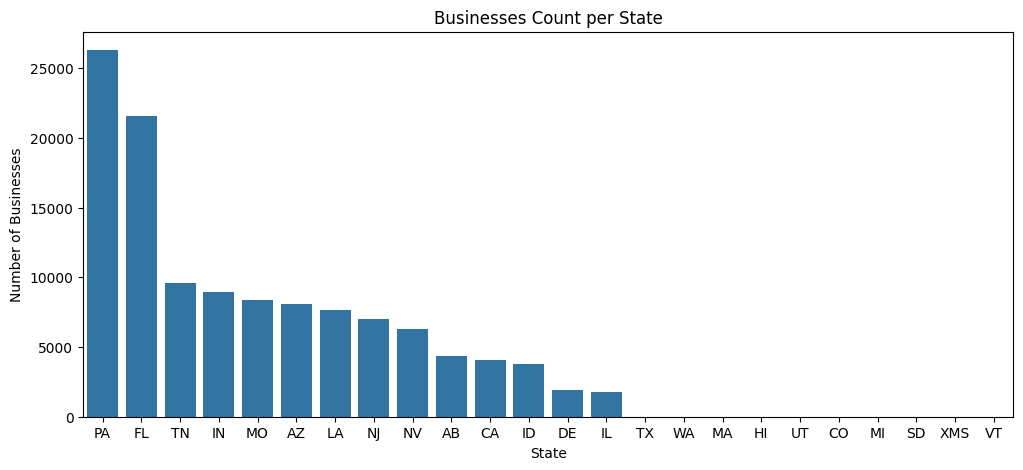

In [7]:
state_counts = biz['state'].value_counts()
plt.figure(figsize=(12, 5))
sns.barplot(x=state_counts.index, y=state_counts.values)
plt.xlabel("State")
plt.ylabel("Number of Businesses")
plt.title("Businesses Count per State")
plt.show()

In [8]:
# Get businesses in most popular state
biz = biz[biz['state'] == "PA"]
print("Filtered Business Shape (Open & PA):", biz.shape)
biz.head(3)

Filtered Business Shape (Open & PA): (26289, 14)


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."
15,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,245,1,"{'RestaurantsReservations': 'True', 'Restauran...","Sushi Bars, Restaurants, Japanese","{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-..."


#### Extracting Restaurants Businesses
Since our project is a restaurant recommendation system, we extracted restaurant businesses.

When looking through the unique business categories with "restaurant", we noticed that there were other categories "Restaurant Supplies" and "Pop-Up Restaurants". To ensure we only extract restaurant businesses (not the "Restaurant Supplies" category), we filtered for businesses that have "Restaurants" as a standalone category.

In [9]:
# Count occurrences of each restaurant-related category, handling NaN values
restaurant_category_counts = biz['categories'].dropna().str.split(', ').explode()
restaurant_category_counts = restaurant_category_counts[restaurant_category_counts.str.lower().str.contains('restaurant', na=False)].value_counts()
print("Count of Each Restaurant-Related Category:")
print(restaurant_category_counts)

Count of Each Restaurant-Related Category:
categories
Restaurants            8069
Pop-Up Restaurants       10
Restaurant Supplies       5
Name: count, dtype: int64


In [10]:
biz = biz[['business_id', 'name', 'city', 'postal_code', 'categories', 'attributes', 'stars']]

# Get only restaurants
restaurants = biz[biz['categories'].str.contains(
    'Restaurants') == True].reset_index()

# Ensure attributes is always a dictionary
restaurants["attributes"] = restaurants["attributes"].apply(
    lambda x: x if isinstance(x, dict) else {})

# Normalize attributes column
attributes_df = pd.json_normalize(restaurants["attributes"])

# Concatenate the main dataframe with the expanded attributes
restaurants = restaurants.drop(columns=["attributes"]).join(attributes_df)

for att in ["Alcohol", "WiFi", "RestaurantsAttire", "NoiseLevel", "BYOBCorkage", "AgesAllowed", "Smoking"]:
    restaurants[att] = restaurants[att].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

restaurants['RestaurantsPriceRange2'] = pd.to_numeric(
    restaurants['RestaurantsPriceRange2'], errors='coerce')

for att in ["Ambience", "BusinessParking", "GoodForMeal", "Music", "BestNights", "DietaryRestrictions"]:
    restaurants[att] = restaurants[att].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    restaurants[att] = restaurants[att].apply(
        lambda x: ", ".join([k for k, v in x.items() if v]
                            ) if isinstance(x, dict) else ""
    )
    

def clean_values(x):
    """Cleans and standardizes values across columns."""
    if isinstance(x, str):
        x_lower = x.strip().lower()
        if x_lower in ["true"]:
            return True
        elif x_lower in ["false"]:
            return False
        elif x_lower in ["none", "nan", "null", ""]:
            return np.nan  # Convert both "None" and "nan" strings to pd.NA
        return x  # Keep other strings unchanged
    elif pd.isna(x) or x is None:
        return np.nan  # Convert NaN and None to pd.NA
    return x  # Keep other values unchanged

# Apply cleaning function to all columns
restaurants = restaurants.apply(lambda col: col.map(clean_values))

# Drop columns
restaurants = restaurants.drop(columns=['index'])

pd.set_option("display.max_columns", None)
print("Filtered Restaurant Businesses Shape:", restaurants.shape)
restaurants.head()

Filtered Restaurant Businesses Shape: (8069, 44)


,business_id,name,city,postal_code,categories,stars,RestaurantsDelivery,OutdoorSeating,BusinessAcceptsCreditCards,BusinessParking,BikeParking,RestaurantsPriceRange2,RestaurantsTakeOut,ByAppointmentOnly,WiFi,Alcohol,Caters,RestaurantsReservations,RestaurantsGoodForGroups,RestaurantsAttire,HasTV,Ambience,GoodForKids,GoodForMeal,NoiseLevel,DogsAllowed,HappyHour,WheelchairAccessible,RestaurantsTableService,Smoking,CoatCheck,Music,BYOB,BusinessAcceptsBitcoin,BestNights,GoodForDancing,DriveThru,BYOBCorkage,Corkage,Open24Hours,AgesAllowed,AcceptsInsurance,RestaurantsCounterService,DietaryRestrictions
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,19107,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",4.0,False,False,False,street,True,1.0,True,False,free,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,Philadelphia,19106,"Sushi Bars, Restaurants, Japanese",4.0,True,True,True,street,NaN,2.0,True,NaN,free,full_bar,NaN,True,True,casual,False,classy,False,"dessert, dinner",average,False,True,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ROeacJQwBeh05Rqg7F6TCg,BAP,Philadelphia,19147,"Korean, Restaurants",4.5,NaN,NaN,True,street,True,1.0,True,NaN,no,NaN,True,False,False,casual,True,casual,True,"lunch, dinner",quiet,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,kV_Q1oqis8Qli8dUoGpTyQ,Ardmore Pizza,Ardmore,19003,"Pizza, Restaurants",3.5,True,False,True,"street, lot",True,1.0,True,NaN,no,NaN,True,False,True,casual,True,casual,True,"latenight, dinner",average,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,aPNXGTDkf-4bjhyMBQxqpQ,Craft Hall,Philadelphia,19123,"Eatertainment, Arts & Entertainment, Brewpubs,...",3.5,True,True,True,lot,NaN,2.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,classy,True,NaN,NaN,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
for col in restaurants.iloc[:, 6:].columns:
    unique_values = restaurants[col].unique()  # Get unique values
    print(f"{col}: {unique_values}")

RestaurantsDelivery: [False True nan]
OutdoorSeating: [False True nan]
BusinessAcceptsCreditCards: [False True nan]
BusinessParking: ['street' 'street, lot' 'lot' nan 'garage, street' 'lot, valet'
 'garage, street, validated, lot' 'street, lot, valet'
 'garage, street, lot' 'street, valet' 'garage, validated'
 'garage, street, validated, lot, valet' 'validated'
 'garage, street, valet' 'garage, lot' 'garage' 'valet'
 'street, validated, valet' 'garage, street, validated, valet'
 'garage, street, validated' 'street, validated' 'validated, valet'
 'garage, lot, valet' 'validated, lot' 'garage, valet'
 'street, validated, lot' 'garage, validated, lot' 'valet, lot'
 'street, validated, lot, valet']
BikeParking: [True nan False]
RestaurantsPriceRange2: [ 1.  2. nan  3.  4.]
RestaurantsTakeOut: [True nan False]
ByAppointmentOnly: [False nan True]
WiFi: ['free' 'no' nan 'paid']
Alcohol: [nan 'full_bar' 'beer_and_wine']
Caters: [True nan False]
RestaurantsReservations: [nan True False]
Restaur

In [12]:
sorted_columns = restaurants.count().sort_values(ascending=False).index
restaurants = restaurants[sorted_columns]
restaurants.info()
restaurants.describe().round(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8069 entries, 0 to 8068
Data columns (total 44 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   business_id                 8069 non-null   object 
 1   city                        8069 non-null   object 
 2   postal_code                 8069 non-null   object 
 3   categories                  8069 non-null   object 
 4   stars                       8069 non-null   float64
 5   name                        8069 non-null   object 
 6   RestaurantsTakeOut          7471 non-null   object 
 7   BusinessAcceptsCreditCards  7181 non-null   object 
 8   RestaurantsDelivery         7149 non-null   object 
 9   RestaurantsPriceRange2      6581 non-null   float64
 10  RestaurantsReservations     6376 non-null   object 
 11  HasTV                       6366 non-null   object 
 12  OutdoorSeating              6192 non-null   object 
 13  RestaurantsGoodForGroups    6004 

,stars,RestaurantsPriceRange2
count,8069.00,6581.00
mean,3.56,1.59
std,0.81,0.59
min,1.00,1.00
25%,3.00,1.00
50%,3.50,2.00
75%,4.00,2.00
max,5.00,4.00


In [13]:
demographics = pd.read_csv("us_census/demographics_merged.csv")
restaurants['postal_code'] = restaurants["postal_code"].astype('str')
demographics['postal_code'] = demographics['postal_code'].astype('str')
restaurants = restaurants.merge(demographics, how="left", on="postal_code")
restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8069 entries, 0 to 8068
Data columns (total 48 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   business_id                      8069 non-null   object 
 1   city                             8069 non-null   object 
 2   postal_code                      8069 non-null   object 
 3   categories                       8069 non-null   object 
 4   stars                            8069 non-null   float64
 5   name                             8069 non-null   object 
 6   RestaurantsTakeOut               7471 non-null   object 
 7   BusinessAcceptsCreditCards       7181 non-null   object 
 8   RestaurantsDelivery              7149 non-null   object 
 9   RestaurantsPriceRange2           6581 non-null   float64
 10  RestaurantsReservations          6376 non-null   object 
 11  HasTV                            6366 non-null   object 
 12  OutdoorSeating      

In [14]:
unique_counts_restaurants = restaurants.nunique()
unique_counts_restaurants

business_id                        8069
city                                266
postal_code                         226
categories                         5771
stars                                 9
name                               6368
RestaurantsTakeOut                    2
BusinessAcceptsCreditCards            2
RestaurantsDelivery                   2
RestaurantsPriceRange2                4
RestaurantsReservations               2
HasTV                                 2
OutdoorSeating                        2
RestaurantsGoodForGroups              2
WiFi                                  3
GoodForKids                           2
BikeParking                           2
RestaurantsAttire                     3
Caters                                2
BusinessParking                      28
NoiseLevel                            4
Ambience                             91
GoodForMeal                          65
RestaurantsTableService               2
WheelchairAccessible                  2


In [15]:
# Find top 5 unique values for specific features
print("Top 5 unique values for name:")
for val in restaurants['name'].value_counts().head(5).index.tolist():
    print(val)

print("\nTop 5 unique values for city:")
for val in restaurants['city'].value_counts().head(5).index.tolist():
    print(val)

"""print("\nTop 5 unique values for categories:")
for val in restaurants['categories'].value_counts().head(5).index.tolist():
    print(val)"""

Top 5 unique values for name:
Wawa
McDonald's
Dunkin'
Wendy's
Domino's Pizza

Top 5 unique values for city:
Philadelphia
West Chester
Bensalem
Norristown
Pottstown


'print("\nTop 5 unique values for categories:")\nfor val in restaurants[\'categories\'].value_counts().head(5).index.tolist():\n    print(val)'

## Dataset 2: Reviews (From Yelp)

In [16]:
# Convert streamed data to a Pandas DataFrame
review_data_raw = pd.DataFrame(stream_jsonl(
    "yelp_academic_dataset_review.json"))
print("Dataframe Shape:", review_data_raw.shape)
review_data_raw.head(3)

Dataframe Shape: (6990280, 9)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30


In [17]:
review_data_raw.info()
review_data_raw.describe().round(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6990280 entries, 0 to 6990279
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   review_id    object 
 1   user_id      object 
 2   business_id  object 
 3   stars        float64
 4   useful       int64  
 5   funny        int64  
 6   cool         int64  
 7   text         object 
 8   date         object 
dtypes: float64(1), int64(3), object(5)
memory usage: 480.0+ MB


,stars,useful,funny,cool
count,6990280.00,6990280.00,6990280.00,6990280.00
mean,3.75,1.18,0.33,0.50
std,1.48,3.25,1.69,2.17
min,1.00,-1.00,-1.00,-1.00
25%,3.00,0.00,0.00,0.00
50%,4.00,0.00,0.00,0.00
75%,5.00,1.00,0.00,0.00
max,5.00,1182.00,792.00,404.00


### Subsampling Strategy

#### Filtering for reviews for restaurants in PA

In [18]:
pa_restaurant_ids = set(restaurants['business_id'])
pa_reviews = review_data_raw[review_data_raw['business_id'].isin(pa_restaurant_ids)].copy()
print("Filtered Pennsylvania Reviews Shape:", pa_reviews.shape)
pa_reviews.head(3)

Filtered Pennsylvania Reviews Shape: (836680, 9)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
16,oyaMhzBSwfGgemSGuZCdwQ,Dd1jQj7S-BFGqRbApFzCFw,YtSqYv1Q_pOltsVPSx54SA,5.0,0,0,0,Tremendous service (Big shout out to Douglas) ...,2013-06-24 11:21:25


In [19]:
# Change date to datetime format for describe() to work
pa_reviews['date'] = pd.to_datetime(pa_reviews['date'])
pa_reviews.info()
pa_reviews.describe().round(2)

<class 'pandas.core.frame.DataFrame'>
Index: 836680 entries, 0 to 6990272
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   review_id    836680 non-null  object        
 1   user_id      836680 non-null  object        
 2   business_id  836680 non-null  object        
 3   stars        836680 non-null  float64       
 4   useful       836680 non-null  int64         
 5   funny        836680 non-null  int64         
 6   cool         836680 non-null  int64         
 7   text         836680 non-null  object        
 8   date         836680 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 63.8+ MB


,stars,useful,funny,cool,date
count,836680.00,836680.00,836680.00,836680.00,836680
mean,3.79,1.05,0.34,0.49,2016-09-25 13:15:53.063883008
min,1.00,0.00,0.00,0.00,2005-02-16 04:06:26
25%,3.00,0.00,0.00,0.00,2014-08-01 07:33:11.500000
50%,4.00,0.00,0.00,0.00,2017-03-06 22:38:15.500000
75%,5.00,1.00,0.00,0.00,2019-04-10 12:23:19.249999872
max,5.00,224.00,227.00,163.00,2022-01-19 19:46:34
std,1.36,2.48,1.39,1.84,NaN


In [20]:
unique_counts_pa_reviews = pa_reviews.nunique()
unique_counts_pa_reviews

review_id      836680
user_id        269462
business_id      8069
stars               5
useful             95
funny              69
cool               89
text           834942
date           834979
dtype: int64

In [21]:
# Calculate sparsity of the user-business interaction matrix
num_users = pa_reviews['user_id'].nunique()
num_businesses = pa_reviews['business_id'].nunique()
rated_count = len(pa_reviews)
total_possible = num_users * num_businesses
sparsity = 1 - (rated_count / total_possible)

print("Number of users:", num_users)
print("Number of businesses:", num_businesses)
print("Number of rated interactions:", rated_count)
print("Total possible user-business interactions:", total_possible)
print(f"Sparsity of the dataset: {sparsity:.4f}")

Number of users: 269462
Number of businesses: 8069
Number of rated interactions: 836680
Total possible user-business interactions: 2174288878
Sparsity of the dataset: 0.9996


### Feature Engineering 

#### Review Text Length

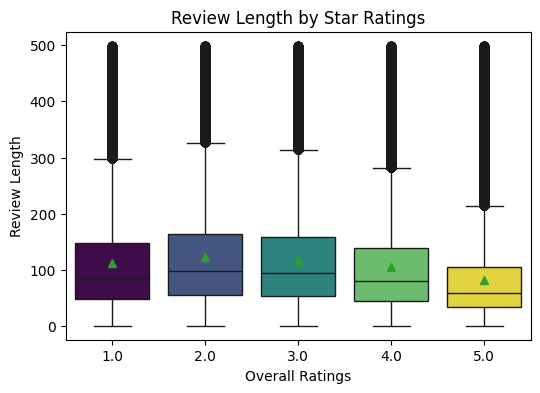

In [22]:
df_r = pa_reviews.copy()

df_r['text_length'] = df_r['text'].apply(lambda x: len(x.split(" ")))

df_r_temporary = df_r[df_r['text_length'] < 500].copy()

plt.figure(figsize=(6, 4))
sns.boxplot(x='stars', y='text_length', data=df_r_temporary, hue='stars',
            showmeans=True, palette='viridis', legend=False)
plt.title('Review Length by Star Ratings')
plt.xlabel('Overall Ratings')
plt.ylabel('Review Length')

plt.show()

In [23]:
print("With review text length:", df_r.shape)
df_r.head(3)

With review text length: (836680, 10)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,text_length
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,101
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,48
16,oyaMhzBSwfGgemSGuZCdwQ,Dd1jQj7S-BFGqRbApFzCFw,YtSqYv1Q_pOltsVPSx54SA,5.0,0,0,0,Tremendous service (Big shout out to Douglas) ...,2013-06-24 11:21:25,42


#### Processed Review Text

In [24]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...


True

In [25]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [26]:
### processed_review
def process_text(text):
    # Convert to Lowercase (0.1 marks)
    text_lower = text.lower()

    # Tokenization (0.1 marks)
    tokens = word_tokenize(text_lower)

    # Filter Alphabetic Tokens (0.1 marks)
    alphabetic_tokens = [word for word in tokens if re.match('^[a-zA-Z]+$', word)]

    # Remove Stopwords and Negation Words
    stop_words = set(stopwords.words('english'))
    # Negation words that should not be removed (0.1 marks)
    negation_words = ['not', 'no', 'never', "n't", "isn't", "aren't", "wasn't", "weren't", "hasn't", "haven't",
                      "doesn't", "don't", "didn't", "won't", "wouldn't", "shan't", "shouldn't", "mustn't", "can't", "cannot"]
    # Create a list of tokens without stopwords and preserving negation words
    tokens_no_stopwords = [word for word in alphabetic_tokens if ((word not in stop_words) or (word in negation_words))]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    # Apply lemmatization to each token (0.1 marks)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens_no_stopwords]

    # Join the lemmatized tokens into a single processed text (0.1 marks)
    processed_text = ' '.join(lemmatized_words)

    return processed_text


In [ ]:
df_r['processed_review'] = df_r['text'].apply(process_text)
print("With processed review:", df_r.shape)
df_r.head(3)

In [ ]:
# Download NLTK resources for part-of-speech tagging
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Define function to extract adjectives
def extract_adjectives(text):
    """
    Extracts adjectives from a given text.

    Parameters:
    - text (str): The input text from which adjectives will be extracted.

    Returns:
    - list: A list of adjectives extracted from the input text.
    """

    # Tokenize the input text
    tokens = word_tokenize(text)

    # Perform part-of-speech tagging on the tokens
    pos_tags = pos_tag(tokens) # (0.1 marks)

    # Extract adjectives based on their part-of-speech tags
    adjectives = [word for word, pos in pos_tags if pos in ["JJ"]] # (0.1 marks)

    # Return the list of extracted adjectives
    return adjectives

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\woowe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\woowe\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
# Define function to generate Word Cloud for adjectives
def generate_word_cloud_adjectives(text, title):
    """
    Generates a Word Cloud visualization for adjectives extracted from the input text.

    Parameters:
    - text (str): The input text from which adjectives will be extracted and visualized.

    Returns:
    - None: Displays the generated Word Cloud plot.
    """

    # Extract adjectives using the previously defined extract_adjectives function
    adjectives = extract_adjectives(text)

    # Create a WordCloud object with specific configurations (0.1 marks)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(adjectives))

    # Plot the Word Cloud (0.1 marks)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [ ]:
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\woowe\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

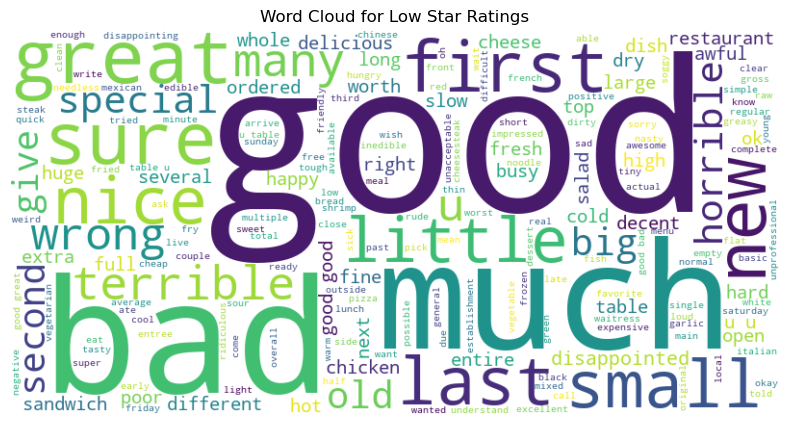

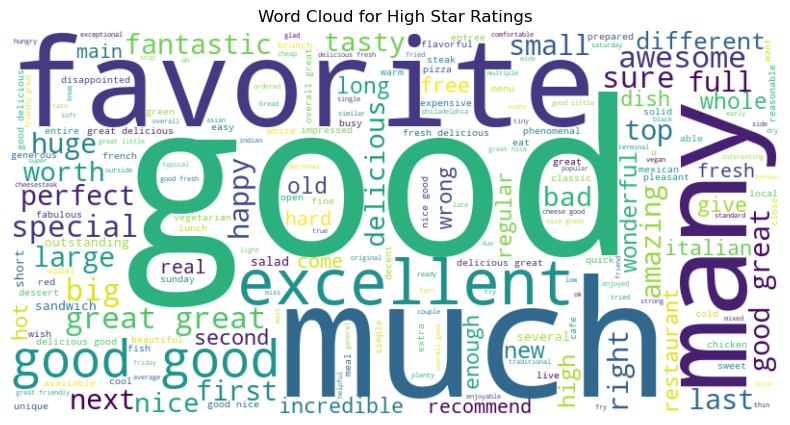

In [ ]:
low_star_reviews = " ".join(df_r[df_r['stars'] < 3]['processed_review'])
high_star_reviews = " ".join(df_r[df_r['stars'] > 3]['processed_review'])

# Generate Word Clouds for adjectives in low and high star reviews (0.1 marks)
generate_word_cloud_adjectives(low_star_reviews, "Word Cloud for Low Star Ratings")
generate_word_cloud_adjectives(high_star_reviews, "Word Cloud for High Star Ratings")

#### Sum of votes for each review

In [ ]:
df_r['sum_votes'] = df_r[['funny', 'useful', 'cool']].fillna(0).sum(axis=1)
print("With sum_votes:", df_r.shape)
df_r.head(3)

With sum_votes: (836680, 12)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,text_length,processed_review,sum_votes
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,101,decide eat aware going take hour beginning end...,0
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,48,wow yummy different delicious favorite lamb cu...,2
16,oyaMhzBSwfGgemSGuZCdwQ,Dd1jQj7S-BFGqRbApFzCFw,YtSqYv1Q_pOltsVPSx54SA,5.0,0,0,0,Tremendous service (Big shout out to Douglas) ...,2013-06-24 11:21:25,42,tremendous service big shout douglas complemen...,0


#### Decay Factor and Weighted Reviews

In [ ]:
# Compute review age in days
baseline_date = datetime(2025, 1, 1)
df_r['review_age_days'] = (baseline_date - pd.to_datetime(df_r['date'])).dt.days

# Function to apply time decay
def apply_time_decay(df, decay_factor):
    df = df.copy()
    df.loc[:, 'review_weight'] = np.exp(-df['review_age_days'] / decay_factor)
    df.loc[:, 'weighted_stars'] = df['stars'] * df['review_weight']
    return df

# Split data into 80% train, 20% test
train_data, test_data = train_test_split(df_r, test_size=0.2, random_state=42)

# Cross-validation with 80% training data using decay factors in multiples of 365
decay_factors = [365, 730, 1095, 1460, 1825, 2190, 2555, 2920, 3285, 3650, 4015, 4380, 4745, 5110, 5475, 5840, 6205, 6570, 6935, 7000]
cv_results = {}
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for decay in decay_factors:
    mse_scores = []
    
    for train_index, val_index in kf.split(train_data):
        train_df, val_df = train_data.iloc[train_index].copy(), train_data.iloc[val_index].copy()
        
        # Apply time decay
        train_df = apply_time_decay(train_df, decay)
        val_df = apply_time_decay(val_df, decay)
        
        # Compute mean weighted rating per business
        business_avg_weighted_rating = train_df.groupby('business_id')['weighted_stars'].mean().fillna(0)
        
        # Predict validation ratings using the business averages
        val_df.loc[:, 'predicted_rating'] = val_df['business_id'].map(business_avg_weighted_rating).fillna(3)
        
        # Compute MSE
        mse = mean_squared_error(val_df['stars'], val_df['predicted_rating'])
        mse_scores.append(mse)
    
    # Store average MSE for this decay factor
    cv_results[decay] = np.mean(mse_scores)

# Find the best decay factor
best_decay = min(cv_results, key=cv_results.get)
print("Best Decay Factor:", best_decay)
print("Cross-validation MSE Scores:", cv_results)

# Apply the best decay factor to the dataset
df_r = apply_time_decay(df_r.copy(), best_decay)


Best Decay Factor: 7000
Cross-validation MSE Scores: {365: 16.09073240558896, 730: 15.01834483218093, 1095: 13.37694504823276, 1460: 11.72082860050505, 1825: 10.256471991065819, 2190: 9.02257735626704, 2555: 8.00005129085874, 2920: 7.155395752816953, 3285: 6.455650911083708, 3650: 5.872666876106163, 4015: 5.383635348876369, 4380: 4.97045627453195, 4745: 4.618861706819419, 5110: 4.317602067631253, 5475: 4.057774234912017, 5840: 3.8322926923756517, 6205: 3.6354818460150127, 6570: 3.4627642601381323, 6935: 3.3104225751729275, 7000: 3.285190027284705}


In [ ]:
print("With time decay etc:", df_r.shape)
df_r.head(3)

With time decay etc: (836680, 15)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,text_length,processed_review,sum_votes,review_age_days,review_weight,weighted_stars
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,101,decide eat aware going take hour beginning end...,0,2369,0.712890,2.138669
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,48,wow yummy different delicious favorite lamb cu...,2,3649,0.593757,2.968783
16,oyaMhzBSwfGgemSGuZCdwQ,Dd1jQj7S-BFGqRbApFzCFw,YtSqYv1Q_pOltsVPSx54SA,5.0,0,0,0,Tremendous service (Big shout out to Douglas) ...,2013-06-24 11:21:25,42,tremendous service big shout douglas complemen...,0,4208,0.548185,2.740924


In [ ]:
df_r.info()

<class 'pandas.core.frame.DataFrame'>
Index: 836680 entries, 0 to 6990272
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   review_id         836680 non-null  object        
 1   user_id           836680 non-null  object        
 2   business_id       836680 non-null  object        
 3   stars             836680 non-null  float64       
 4   useful            836680 non-null  int64         
 5   funny             836680 non-null  int64         
 6   cool              836680 non-null  int64         
 7   text              836680 non-null  object        
 8   date              836680 non-null  datetime64[ns]
 9   text_length       836680 non-null  int64         
 10  processed_review  836680 non-null  object        
 11  sum_votes         836680 non-null  int64         
 12  review_age_days   836680 non-null  int64         
 13  review_weight     836680 non-null  float64       
 14  weighted

In [ ]:
df_r.describe().round(2)

,stars,useful,funny,cool,date,text_length,sum_votes,review_age_days,review_weight,weighted_stars
count,836680.00,836680.00,836680.00,836680.00,836680,836680.00,836680.00,836680.00,836680.00,836680.00
mean,3.79,1.05,0.34,0.49,2016-09-25 13:15:53.063883008,103.46,1.88,3019.01,0.66,2.50
min,1.00,0.00,0.00,0.00,2005-02-16 04:06:26,1.00,0.00,1077.00,0.35,0.36
25%,3.00,0.00,0.00,0.00,2014-08-01 07:33:11.500000,42.00,0.00,2092.00,0.58,1.77
50%,4.00,0.00,0.00,0.00,2017-03-06 22:38:15.500000,75.00,1.00,2857.00,0.66,2.60
75%,5.00,1.00,0.00,0.00,2019-04-10 12:23:19.249999872,133.00,2.00,3805.00,0.74,3.32
max,5.00,224.00,227.00,163.00,2022-01-19 19:46:34,3079.00,504.00,7258.00,0.86,4.29
std,1.36,2.48,1.39,1.84,NaN,93.59,5.29,1185.81,0.11,1.02


In [ ]:
# Convert streamed data to a Pandas DataFrame
user_data_raw = pd.DataFrame(stream_jsonl(
    "yelp_academic_dataset_user.json"))
print("Dataframe Shape:", user_data_raw.shape)
user_data_raw.head(3)

Dataframe Shape: (1987897, 22)


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,3.91,250,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,3.74,1145,264,184,157,251,1847,7054,3131,3131,1521,1946
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,3.32,89,13,10,17,3,66,96,119,119,35,18


In [ ]:
# Filter users who reviewed businesses in the business dataset
valid_business_ids = set(restaurants['business_id'])
filtered_reviews = df_r[df_r['business_id'].isin(valid_business_ids)]
valid_user_ids = set(filtered_reviews['user_id'])
filtered_users = user_data_raw[user_data_raw['user_id'].isin(valid_user_ids)]

print("Filtered User Data Shape:", filtered_users.shape)

Filtered User Data Shape: (269461, 22)


In [ ]:
filtered_users.head(3)

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,3.91,250,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,3.74,1145,264,184,157,251,1847,7054,3131,3131,1521,1946
5,q_QQ5kBBwlCcbL1s4NVK3g,Jane,1221,2005-03-14 20:26:35,14953,9940,11211,"2006,2007,2008,2009,2010,2011,2012,2013,2014","xBDpTUbai0DXrvxCe3X16Q, 7GPNBO496aecrjJfW6UWtg...",1357,3.85,1713,163,191,361,147,1212,5696,2543,2543,815,323


In [ ]:
filtered_users.info()

<class 'pandas.core.frame.DataFrame'>
Index: 269461 entries, 0 to 1987892
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   user_id             269461 non-null  object 
 1   name                269461 non-null  object 
 2   review_count        269461 non-null  int64  
 3   yelping_since       269461 non-null  object 
 4   useful              269461 non-null  int64  
 5   funny               269461 non-null  int64  
 6   cool                269461 non-null  int64  
 7   elite               269461 non-null  object 
 8   friends             269461 non-null  object 
 9   fans                269461 non-null  int64  
 10  average_stars       269461 non-null  float64
 11  compliment_hot      269461 non-null  int64  
 12  compliment_more     269461 non-null  int64  
 13  compliment_profile  269461 non-null  int64  
 14  compliment_cute     269461 non-null  int64  
 15  compliment_list     269461 non-null  i

In [ ]:
filtered_users.describe().round(2)

,review_count,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
count,269461.00,269461.00,269461.00,269461.00,269461.00,269461.00,269461.00,269461.00,269461.00,269461.00,269461.00,269461.00,269461.00,269461.00,269461.00,269461.00,269461.00
mean,38.28,81.85,34.74,49.43,2.85,3.66,3.55,0.54,0.36,0.24,0.14,3.03,6.12,5.64,5.64,2.09,2.50
std,140.04,1150.74,775.49,1019.21,36.12,1.06,119.88,14.75,20.74,9.16,8.02,145.58,239.22,164.63,164.63,52.32,146.24
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,3.00,1.00,0.00,0.00,0.00,3.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,8.00,4.00,1.00,1.00,0.00,3.85,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,24.00,20.00,4.00,5.00,1.00,4.40,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,17473.00,206296.00,185823.00,199878.00,12497.00,5.00,25784.00,4347.00,7039.00,2974.00,2607.00,59031.00,101097.00,49967.00,49967.00,15934.00,56104.00


In [ ]:
print("Unique Users in Review Data:", df_r['user_id'].nunique())
print("Unique Users in User Data:", filtered_users['user_id'].nunique())

Unique Users in Review Data: 269462
Unique Users in User Data: 269461


In [ ]:
# Find users in review dataset but not in user dataset
users_not_in_user_dataset = set(df_r['user_id']) - set(user_data_raw['user_id'])

print("Number of Users in Review Dataset but Not in User Dataset:", len(users_not_in_user_dataset))
if len(users_not_in_user_dataset) > 0:
    print("Sample Missing Users:", list(users_not_in_user_dataset)[:5])

Number of Users in Review Dataset but Not in User Dataset: 1
Sample Missing Users: ['MaengE6zJ6k_d5e6nwnVaA']


In [ ]:
# Print row for specific user_id in both datasets
user_id_to_search = "MaengE6zJ6k_d5e6nwnVaA"
user_reviews = df_r[df_r['user_id'] == user_id_to_search]
user_reviews

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,text_length,processed_review,sum_votes,review_age_days,review_weight,weighted_stars
2076660,GZmjLeVfDktqx7xZvAHBSg,MaengE6zJ6k_d5e6nwnVaA,kZTwub3IkBCDHYW5J5pRrA,1.0,0,0,0,Ordered 2 meatball park sandwiches both sandwi...,2022-01-19 17:45:25,35,ordered meatball park sandwich sandwich cooked...,0,1077,0.857394,0.857394


In [ ]:
user_info = user_data_raw[user_data_raw['user_id'] == user_id_to_search]
user_info

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos


In [ ]:
# Save dataframes to CSV
df_r.to_csv("df_r.csv", index=False)
restaurants.to_csv("restaurants.csv", index=False)
filtered_users.to_csv("filtered_users.csv", index=False)

print("CSV files saved: df_r.csv, restaurants.csv, filtered_users.csv")

CSV files saved: df_r.csv, restaurants.csv, filtered_users.csv
